In [16]:
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install "tensorflow<2.14"
%pip install "tensorflow-addons<0.24"
%pip install "tensorflow-datasets<5.0"
%pip install "tensorflow-hub<0.14"
%pip install "tensorflow-metadata<1.14"
%pip install "tensorflow-text<2.14"
%pip install "tensorflow-io<0.30"
%pip install "tensorflow-probability<0.24"
%pip install "tensorflow-model-optimization<0.8"
%pip install "tensorflow-privacy<0.8"
%pip install "tensorflow-federated<0.24"
%pip install "tensorflow-graphics<0.20"
%pip install "tensorflow-quantum<0.8"

ERROR: Could not find a version that satisfies the requirement tensorflow<2.14 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow<2.14
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-addons<0.24 (from versions: none)
ERROR: No matching distribution found for tensorflow-addons<0.24
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-text<2.14 (from versions: 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow-text<2.14
Note: you may need to

In [19]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
    
# loading the dataset for training and testing
img_size = (128, 128)  # resizing the images to stay consistent with each one
batch_size = 32        # set the number of images to process in each training and testing batch
train_dir = './preprocessed_data/Training'   # retrieving the directory for the training data set
test_dir = './preprocessed_data/Testing'     # retrieving the directory for the testing data set

datagen = ImageDataGenerator(rescale=1./255) # normalizing pixel values

# loading in training and testing images
train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# defining a function to generate the images to a numPy array
def imageToNumPy(gen):
    X = [] # creating list for image data 
    y = [] # creating list for image labels

    # loops through all the batches
    for i in range(len(gen)):
        x_batch, y_batch = next(gen) # grabs next batch of images and labels
        X.append(x_batch)            # append to data list
        y.append(y_batch)            # append to label list

    # concatenate all batches into NumPy arrays
    return np.concatenate(X), np.concatenate(y)

# converting training and testing images batches and labels into NumPy arrays
X_train, y_train = imageToNumPy(train_gen)
X_test, y_test = imageToNumPy(test_gen)

# defining a funciton to extract different feature selection: shape, color contrast, and tumor location
def extract_handcrafted_features(images):
    features = []

    # loop through all the images
    for img in images:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)              # converts the images to a greyscale
        equalized = cv2.equalizeHist(gray)                                                 # enhancing the contrast
        edges = cv2.Canny(equalized, 100, 200)                                             # detect edges using canny edge detector 
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find the contours of the tumors
        largest_area = max([cv2.contourArea(cnt) for cnt in contours], default=0)          # compute the area of the largest contour 
        mean_intensity = np.mean(equalized)                                                # calculate the average of the brightness intensity

        # initializing the center of mass
        cx = 0
        cy = 0

        # computing the location of the largest contour by getting the center coordinates of largest shape using contour moments and normalizes location by image width and height
        if contours:
            largest = max(contours, key=cv2.contourArea)
            M = cv2.moments(largest)
            if M["m00"] != 0:
                cx = M["m10"] / M["m00"]
                cy = M["m01"] / M["m00"]
            cx /= img.shape[1]
            cy /= img.shape[0]
        features.append([largest_area, mean_intensity, cx, cy])
        
    # returns a NumPy array with tumor shape area, mean intensity (color contrast), and normalized (x, y) location.
    return np.array(features)

# extracting the shape, contrast, and location features from training and testing images
X_train_feats = extract_handcrafted_features(X_train)
X_test_feats = extract_handcrafted_features(X_test)

# normalizing our feature selection
scaler = StandardScaler()
X_train_feats = scaler.fit_transform(X_train_feats)
X_test_feats = scaler.transform(X_test_feats)

# training with a split: 85% training, 15% validation. testing data is loaded seperatly in a differnt folder
X_img_train, X_img_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_train, X_train_feats, y_train, test_size=0.15, random_state=42
)

# defining the function to build the CNN model with our selected features.
def build_combined_model(input_shape_img, input_shape_feat, num_classes):
    img_input = Input(shape=input_shape_img)              # defining the input layer
    x = Conv2D(32, (3, 3), activation='relu')(img_input)  # 2d conv layer with 32 filters, size 3×3 to detect low-level features
    x = MaxPooling2D(pool_size=(2, 2))(x)                 # max pooling layer to downsample the feature maps
    x = Dropout(0.5)(x)                                   # dropout layer to help prevent overfitting
    x = Conv2D(64, (3, 3), activation='relu')(x)          # second conv2D layer with 64 filter
    x = MaxPooling2D(pool_size=(2, 2))(x)                 # second pooling step to further reduce dimensions and retain strong features
    x = Dropout(0.5)(x)                                   # second dropout layer to continue regularization and prevent overfitting
    x = Flatten()(x)                                      # flatten output to 1d vector

    # combine cnn output with the 3 features and pass through dense layers for classification
    feat_input = Input(shape=input_shape_feat)           
    combined = Concatenate()([x, feat_input])          
    z = Dense(128, activation='relu')(combined)           
    output = Dense(num_classes, activation='softmax')(z)

    # returns the final multi input classification model
    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# building and training the model
num_classes = y_train.shape[1]
model = build_combined_model(X_train.shape[1:], (4,), num_classes)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_img_train, X_feat_train], # training on the images and the features
    y_train,
    validation_data=([X_img_val, X_feat_val], y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop], # stops training if validation loss does not improve
    verbose=1
)

# evaluate the final model performance on unseen test data
test_loss, test_acc = model.evaluate([X_test, X_test_feats], y_test)
print("Test Accuracy: {:.4f}".format(test_acc))

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.4255 - loss: 1.5086 - val_accuracy: 0.7771 - val_loss: 0.6678
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - accuracy: 0.7681 - loss: 0.5875 - val_accuracy: 0.8238 - val_loss: 0.5064
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.8539 - loss: 0.4109 - val_accuracy: 0.8926 - val_loss: 0.3462
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - accuracy: 0.8904 - loss: 0.3017 - val_accuracy: 0.8693 - val_loss: 0.3290
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.9157 - loss: 0.2292 - val_accuracy: 0.9102 - val_loss: 0.2756
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.9389 - loss: 0.1729 - val_accuracy: 0.9218 - val_loss: 0.2365
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.9553 - loss: 0.1253 - val_accuracy: 0.9160 - val_loss: 0.2361

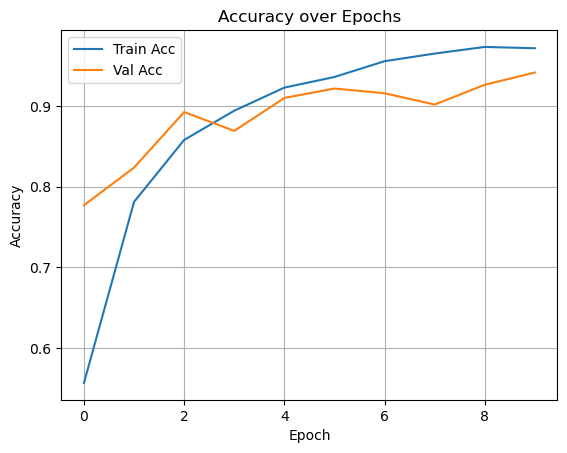

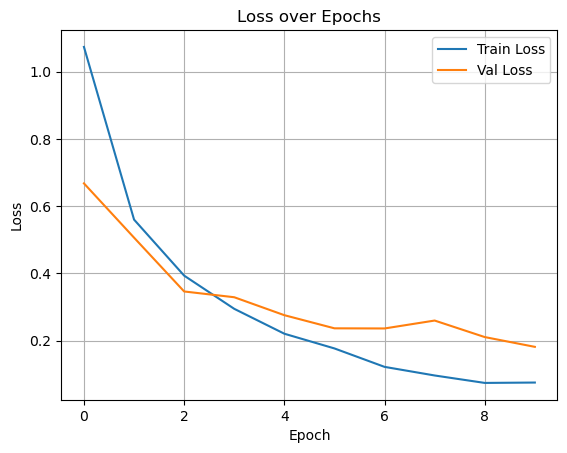

<Figure size 640x480 with 0 Axes>

In [20]:
# Visualize Accuracy & Loss 

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("AccuracyOverEpochs.jpg", dpi=150)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.savefig("LossOverEpochs.jpg", dpi=150)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


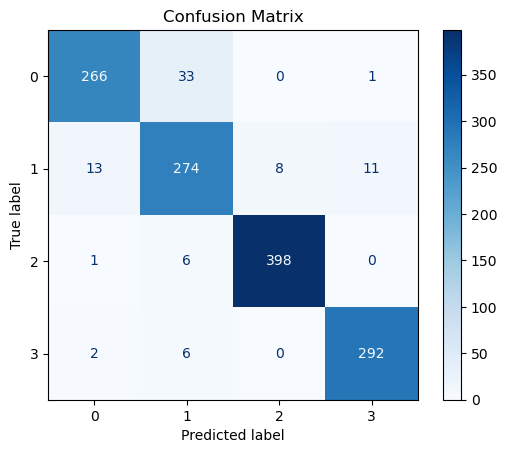

<Figure size 640x480 with 0 Axes>

In [21]:
# confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict([X_test, X_test_feats])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("ConfusionMatrix.jpg", dpi=150)


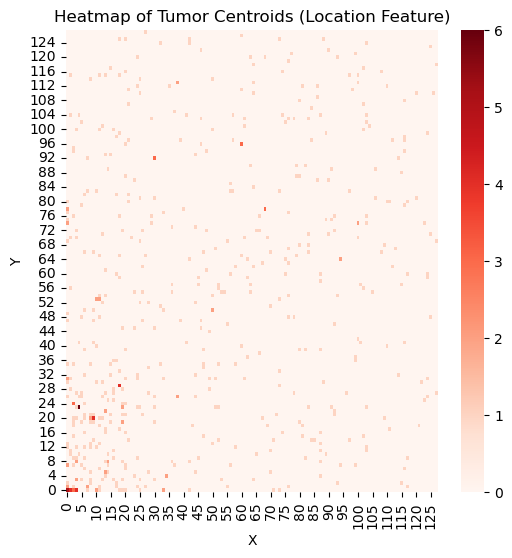

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming H and W are your image dimensions (e.g., 128x128)
H, W = X_train.shape[1:3]
centroids_x = (X_train_feats[:, 2] * W).astype(int)
centroids_y = (X_train_feats[:, 3] * H).astype(int)

heatmap = np.zeros((H, W))
for x, y in zip(centroids_x, centroids_y):
    if 0 <= y < H and 0 <= x < W:
        heatmap[y, x] += 1

plt.figure(figsize=(6, 6))
sns.heatmap(heatmap, cmap="Reds", cbar=True)
plt.title("Heatmap of Tumor Centroids (Location Feature)")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.show()

plt.savefig("HeatmapOfTumorCentroids.jpg", dpi=150)


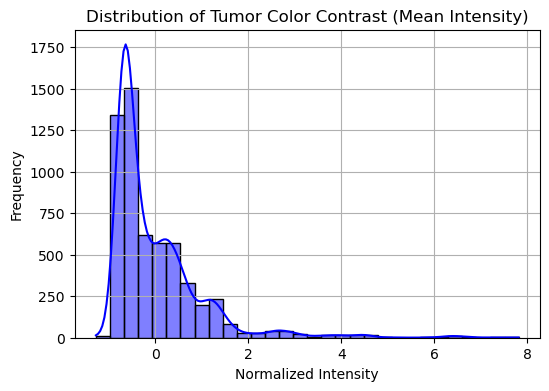

<Figure size 640x480 with 0 Axes>

In [23]:
contrast_vals = X_train_feats[:, 1]

plt.figure(figsize=(6, 4))
sns.histplot(contrast_vals, kde=True, color="blue", bins=30)
plt.title("Distribution of Tumor Color Contrast (Mean Intensity)")
plt.xlabel("Normalized Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
plt.savefig("DistributionOfTumorColorContrast.jpg", dpi=150)

/var/folders/dm/kz4m6xs52kq7sgtrzykzmkhr0000gn/T/ipykernel_36782/3748604400.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_shape, x="Class", y="ShapeArea", palette="Set2")


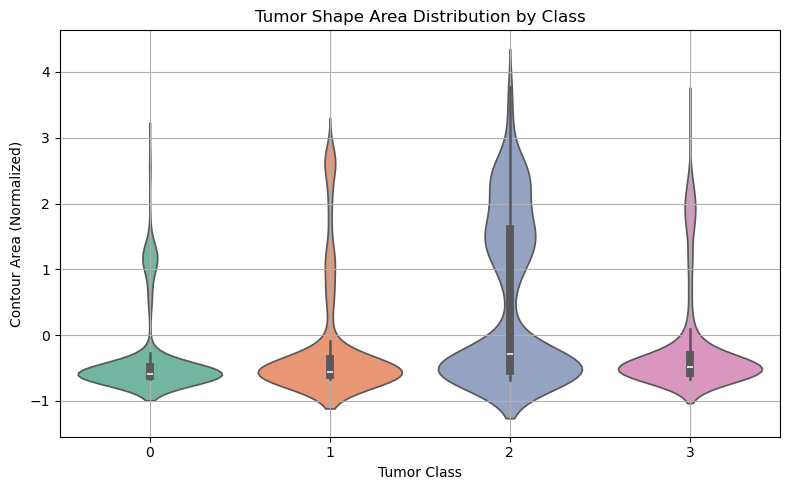

<Figure size 640x480 with 0 Axes>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Make sure you're using the training features and labels ---
# This assumes you split your features like:
# X_feat_train, y_train = ... from train_test_split

# 1. Extract shape areas from handcrafted features (first column)
shape_areas = X_feat_train[:, 0]

# 2. Get class labels from one-hot encoded training labels
class_labels = np.argmax(y_train, axis=1)

# 3. Create a DataFrame for plotting
df_shape = pd.DataFrame({
    "ShapeArea": shape_areas,
    "Class": class_labels
})

# 4. Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=df_shape, x="Class", y="ShapeArea", palette="Set2")
plt.title("Tumor Shape Area Distribution by Class")
plt.xlabel("Tumor Class")
plt.ylabel("Contour Area (Normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("TumorShapeAreaDist.jpg", dpi=150)


In [25]:
%pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Export the trained Keras model to an .h5 file
from pathlib import Path

MODEL_PATH = Path.cwd() / 'brain_tumor_model.h5'   # will save alongside your notebook
model.save(str(MODEL_PATH))
print(f"Model saved to {MODEL_PATH}")


Model saved to /Users/alexdo/Desktop/ECS171_BrainCancerDetection/Project/brain_tumor_model.h5


In [27]:
import joblib
# This writes out the scaler with its learned mean_ and scale_ arrays
joblib.dump(scaler, 'scaler.pkl')
print("scaler saved to scaler.pkl")


scaler saved to scaler.pkl
